In [1]:
GENERAL = "#37ABC8"
CNT = "#6600FF"

# Load Results

In [2]:
import sys
sys.path.append('../')

from scripts.direct_training import direct_training
from scripts.fine_tuning import fine_tuning
from scripts.bucky_sweep import N_TRAINS

direct_df = direct_training.to_dataframe(
    config=dict(
        dataset_name="C-GAP-20:bucky",
        labels="dft_u",
    ),
)

direct_df.groupby("n_train").count()[["id"]].rename({"id": "repeats:"}, axis=1).T

n_train,15,30,60,120,240
repeats:,5,5,5,5,5


In [3]:
general_pretraining = direct_training.to_dataframe(
    config={
        "n_train": 10_000,
        "dataset_name": "C-SYNTH-23M:reasonable",
        "labels": "ace",
    }
)
assert len(general_pretraining) == 1
general_model_id = general_pretraining.iloc[0].id
general_model_id

'23.06.08-20.33.15-394025'

In [4]:
finetune_df = fine_tuning.to_dataframe(
    config=dict(
        pretrain_id=general_model_id,
        finetune_dataset="C-GAP-20:bucky",
        finetune_labels="dft_u",
    ),
)

finetune_df.groupby("n_finetune").count()[["id"]].rename({"id": "repeats:"}, axis=1).T

n_finetune,15,30,60,120,240
repeats:,5,5,5,5,5


In [5]:
# get the pretrained model and evaluate it on the bucky dataset
from src.evaluate import evaluate_model
from src.util import get_model_directory_from

pretrain_results = evaluate_model(
    get_model_directory_from(general_model_id),
    dataset="C-GAP-20:bucky",
    labels="dft_u",
    n_train=10, # dummy value
)['test']
pretrain_results

{'cell_energy_rmse': 46.51772345187405,
 'scaled_energy_rmse': 6.324923524726537,
 'per_atom_energy_rmse': 1.0438830567361466,
 'force_rmse': 0.6782958335003736}

# Plot Results

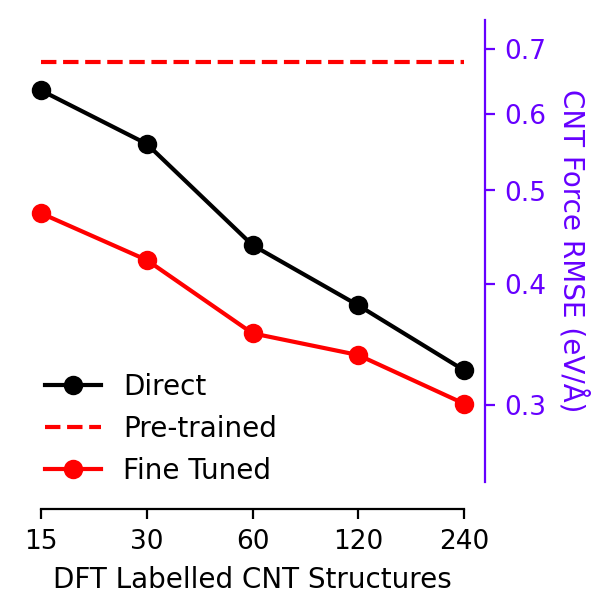

In [6]:
import matplotlib.pyplot as plt
from plotting_utils import style_defaults, colours
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update(style_defaults)

plt.figure(figsize=(3, 3))

direct_results = direct_df.groupby("n_train").min().reset_index()
plt.plot(
    direct_results.n_train,
    direct_results.test_force_rmse,
    'o-', 
    c=colours["dft"], 
    label="Direct",
)

plt.hlines(
    pretrain_results["force_rmse"],
    N_TRAINS[0],
    N_TRAINS[-1],
    linestyles="dashed",
    label="Pre-trained",
    colors=colours["ace"],
)

finetune_results = finetune_df.groupby("n_finetune").min().reset_index()
plt.plot(
    finetune_results.n_finetune,
    finetune_results.test_force_rmse,
    'o-',
    c=colours["ace"],
    label="Fine Tuned"
)

plt.xscale("log")
plt.xticks(N_TRAINS, N_TRAINS)
plt.xlabel("DFT Labelled CNT Structures")

yticks = [0.3, 0.4, 0.5, 0.6, 0.7]
plt.yscale("log")
plt.yticks(yticks, yticks)
plt.ylabel("CNT Force RMSE (eV/Å)", rotation=270, labelpad=15, color=CNT)
plt.ylim(0.25, 0.75)

plt.minorticks_off()

ax = plt.gca()
ax.spines["bottom"].set_position(("outward", 10))
ax.spines["bottom"].set_bounds(N_TRAINS[0], N_TRAINS[-1])

# move ticks, labels and spines to the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(False)

# set the colours of the right spine and yticks 
ax.spines["right"].set_color(CNT)
ax.tick_params(axis="y", colors=CNT)


plt.legend(bbox_to_anchor=(0, -0.06), loc="lower left", frameon=False)
# plt.legend(loc="lower left")

plt.savefig("../figures/bucky-acc.svg", bbox_inches="tight", transparent=True)

In [7]:
import pandas as pd

dataset = "C-GAP-17"
labels = "dft"

direct_results = pd.DataFrame(
    [
        {
            "n_train": row.n_train,
            "force_rmse": evaluate_model(
                directory=get_model_directory_from(row.id),
                dataset=dataset,
                labels=labels,
                n_train=10,  # dummy value
            )["test"]["force_rmse"],
        }
        for row in direct_df.itertuples()
    ]
).groupby("n_train").min().reset_index()

finetune_results = pd.DataFrame(
    [
        {
            "n_finetune": row.n_finetune,
            "force_rmse": evaluate_model(
                directory=get_model_directory_from(row.id),
                dataset=dataset,
                labels=labels,
                n_train=10,  # dummy value
            )["test"]["force_rmse"],
        }
        for row in finetune_df.itertuples()
    ]
).groupby("n_finetune").min().reset_index()

pretrain_general_results = evaluate_model(
    get_model_directory_from(general_model_id),
    dataset=dataset,
    labels=labels,
    n_train=10,  # dummy value
)["test"]
pretrain_results

{'cell_energy_rmse': 46.51772345187405,
 'scaled_energy_rmse': 6.324923524726537,
 'per_atom_energy_rmse': 1.0438830567361466,
 'force_rmse': 0.6782958335003736}

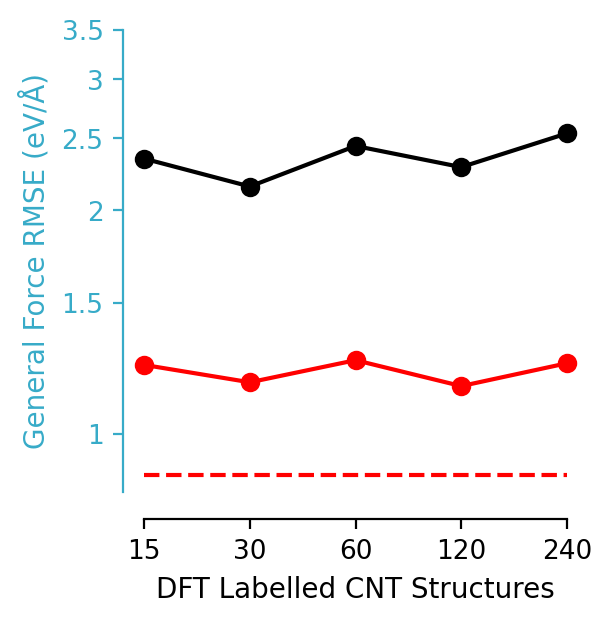

In [8]:
import matplotlib.pyplot as plt
from plotting_utils import style_defaults, colours
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update(style_defaults)

plt.figure(figsize=(3, 3))

plt.plot(
    direct_results.n_train, 
    direct_results.force_rmse,
    'o-', 
    c=colours["dft"], 
    label="Direct"
)

plt.hlines(
    pretrain_general_results["force_rmse"],
    N_TRAINS[0],
    N_TRAINS[-1],
    linestyles="dashed",
    label="Pre-trained",
    colors=colours["ace"],
)

plt.plot(
    finetune_results.n_finetune,
    finetune_results.force_rmse,
    'o-',
    c=colours["ace"],
    label="Fine Tuned"
)

plt.xscale("log")
plt.xticks(N_TRAINS, N_TRAINS)
plt.xlabel("DFT Labelled CNT Structures")

yticks = [1, 1.5, 2, 2.5, 3, 3.5]
plt.yscale("log")
plt.yticks(yticks, yticks)
plt.ylabel("General Force RMSE (eV/Å)", color=GENERAL)

plt.minorticks_off()

ax = plt.gca()
ax.spines["bottom"].set_position(("outward", 10))
ax.spines["bottom"].set_bounds(N_TRAINS[0], N_TRAINS[-1])

# set the colours of the left spine and yticks
ax.spines["left"].set_color(GENERAL)
ax.tick_params(axis="y", colors=GENERAL)

plt.savefig("../figures/bucky-acc-general.svg", bbox_inches="tight", transparent=True)

# SOAP Maps

In [9]:
import numpy as np
from src.data import get_structures_for
from quippy.descriptors import Descriptor

bucky_structures = get_structures_for("C-GAP-20:bucky")
soap_desc = Descriptor("soap cutoff=4.0 l_max=6 n_max=6 atom_sigma=0.5 n_Z=1 Z={6}")

soaps = np.vstack([
    soap_desc.calc_descriptor(structure)
    for structure in bucky_structures
])

Output()

Output()

This dataset is covered by the CC-BY-4.0 license.
Please cite this dataset if you use it in your work.
For more information, visit:
https://jla-gardner.github.io/load-atoms/datasets/C-GAP-20.html


In [10]:
soaps.shape

(16758, 148)

In [11]:
from ase.io import read

general_structures = read("../data/processed/C-SYNTH-23M:reasonable/ace/test.extxyz", ":100")
general_soaps = np.vstack([
    soap_desc.calc_descriptor(structure)
    for structure in general_structures
])

general_soaps.shape

(20000, 148)

In [12]:
from umap import UMAP

# fit a UMAP model to the general structures
# and then project the bucky structures into the same space

umap = UMAP(n_components=2, random_state=42)

general_embedding = umap.fit_transform(general_soaps)
bucky_embedding = umap.transform(soaps)

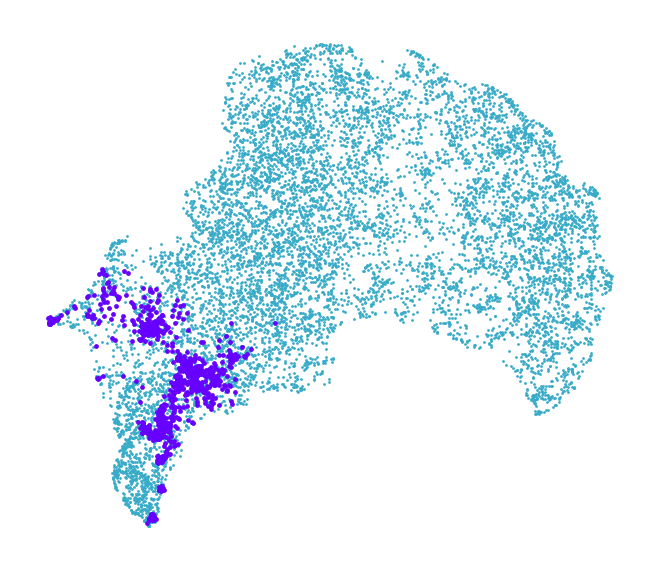

In [13]:
n_to_show = 1000
plt.scatter(*general_embedding[:n_to_show*10].T, s=1, alpha=1, lw=0, color=GENERAL, label="General")
plt.scatter(*bucky_embedding[:n_to_show].T, s=3, alpha=1, lw=0, color=CNT, label="CNTs")
plt.gca().set_aspect("equal")
plt.axis("off")

plt.savefig("../figures/bucky-umap.svg", bbox_inches="tight", transparent=True)

# Perform MD

In [14]:
from src.validation.lammps import nequip_anneal_run

# number of CNT structures seen in training
n_train = 60

direct_model = direct_df[direct_df.n_train == n_train].id.values[0]
finetune_model = finetune_df[finetune_df.n_finetune == n_train].id.values[0]

direct_model, finetune_model

('23.06.13-06.53.33-059587', '23.06.13-06.56.32-792516')

In [ ]:
from src.validation.lammps import nequip_anneal_run

for model_id in (direct_model, finetune_model):
    nequip_anneal_run(
        model_id=model_id,
        starting_density=1.5,
        anneal_T=3000,
        warm_ps=100,
        anneal_ps=900,
        random_seed=1,
    )